In [1]:
import pybamm
pybamm.settings.heaviside_smoothing = 10
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
from scipy.optimize import root

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)
#notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)
########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

# data set when at office 
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
# data set when at home


In [78]:
sat = 0.001
Sp_initial = 10e-3
kp = 100

In [79]:
cap = 0.211

Ms = 32
F = 9.649e4
V = 2.45
R = 8.3145
T = 298
ar = 0.960
I = cap*0.2#1.7
nu = 0.114

#f_l = np.sqrt(nu*Ms/2)# (Ms*nu/2)**(1/2)
#f_m = np.sqrt(nu*Ms)#(4*Ms*nu)**(1/2)
#f_h = np.sqrt(nu*Ms)*2/(8**(1/4))#(16*Ms*nu)**(1/4)

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

ih0 = 5
im0 = 5
il0 = 5


S8_initial = 0.0561

def S1_func(S2):
    constant = f_l*np.exp(F*(EL0-V)/(R*T))
    return constant*np.sqrt(S2)

def S2_func(S4, S8):
    return 0.336 - S4 - S8
#S2_initial = 0.4
def S4_root(S4):

    EH = EH0 + (R*T/F)*np.log( f_h*(S8_initial**(1/4)) / (S4**(1/2)) )
    eta_H = V - EH
    iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))

    S2 = S2_func(S4,S8_initial)

    EM = EM0 + (R*T/F)*np.log( f_m*(S4**(1/2)) / S2 ) 
    eta_M = V - EM
    iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))

    return I - iH - iM

In [80]:
print('S8 initial')
print(S8_initial)

# First find the root for S4
S4 = root(S4_root, 0.16)
S4_initial = S4['x'][0]
print('S4 initial')
print(S4_initial)

# Check root function is successful
print('Root')
print(S4_root(S4_initial))

# Third solve for S2 in terms of S4
#S2_initial = S2_func(S4_initial, S8_initial)
S2_initial = .336 - S8_initial-S4_initial
print('S2 initial')
print(S2_initial)

# check that V = EM0
print('EM0 initial')
print(EM0 + (R*T)*np.log(f_m*(S4_initial**(1/2))/S2_initial)/(F))

# current check
EH = EH0 + (R*T)*np.log(f_h*(S8_initial**(1/4))/(S4_initial**(1/2)))/(F)
eta_H = V - EH
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))
print('iH initial')
print(iH)

EM = EM0 + (R*T/F)*np.log( f_m*(S4_initial**(1/2)) / S2_initial ) 
eta_M = V - EM
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))
print('iM initial')
print(iM)

print('iH+iM')
print(iH+iM)

# Fourth solve for S1 in terms of S2
S1_initial = S1_func(S2_initial)
print('S1 initial')
print(S1_initial)

# check that V = EL0
print('EL0 initial')
print(EL0 + (R*T)*np.log(f_l*(S2_initial**(1/2))/S1_initial)/(F))

S8 initial
0.0561
S4 initial
0.1335286095805121
Root
-7.388881173575612e-14
S2 initial
0.14637139041948793
EM0 initial
2.450109290367728
iH initial
0.021770706064780095
iM initial
0.020429293935293795
iH+iM
0.04220000000007389
S1 initial
2.577675840871397e-10
EL0 initial
2.45


In [93]:


model = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param = model.default_parameter_values
param.update(
    {
        "Current function [A]": .0422,
        "Initial Condition for Terminal Voltage [V]": 2.45,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": sat,
        'gamma': 100,
        'kappa': 50,
        'Shuttle rate coefficient during charge [s-1]': 0,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim = pybamm.Simulation(
    model,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-5,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 4500#16950#3600*hours
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

res failed: KeyboardInterrupt
At t = 3531.84, the residual function failed unrecoverably.


KeyboardInterrupt: 

In [ ]:
plt.plot(sim.solution.t,sim.solution["Terminal voltage [V]"].entries)

In [91]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = 16500#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    else:
        return False

condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(1)
    except:
        condition = False






 Trying 100 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

res failed: KeyboardInterrupt
The residual function failed unrecoverably. 
res failed: KeyboardInterrupt
At t = 3531.2, the residual function failed unrecoverably.







 Trying 50 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






 Trying 10 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 3531.04 and h = 1.20401e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: ...

psetup failed: KeyboardInterrupt
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jac






 Trying 1 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 3531.04 and h

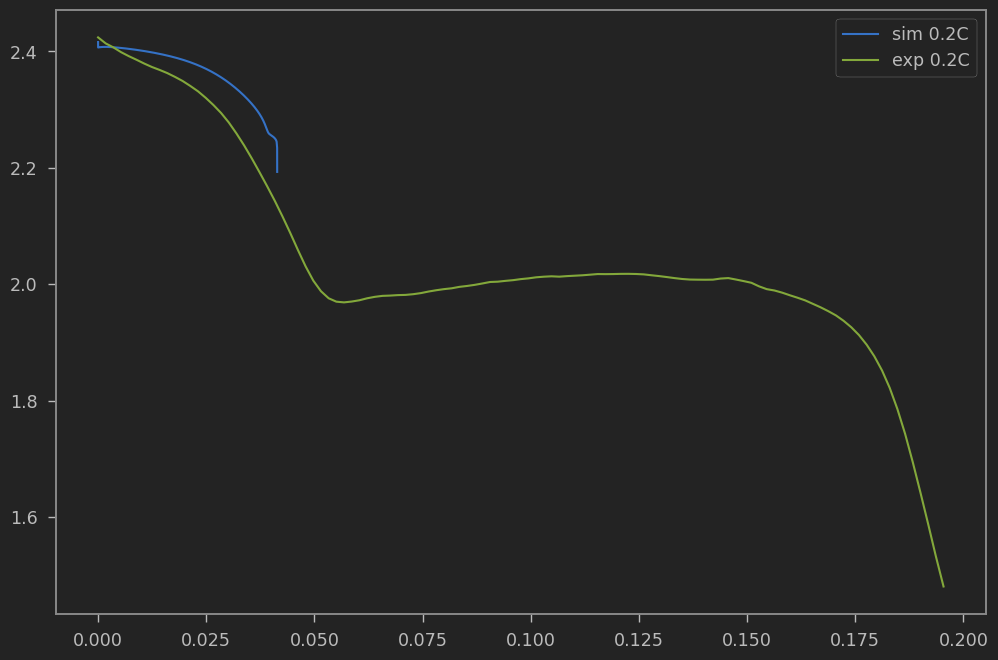

In [92]:
capacity = 0.0422*sim.solution.t/3600
V = sim.solution["Terminal voltage [V]"].entries
plt.plot(capacity, V)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])

In [63]:
# Initial conditions (DoD dependent)
loc = -1
S8_initial_cha = sim.solution['S8 [g]'].entries[loc]
S4_initial_cha = sim.solution['S4 [g]'].entries[loc]
S2_initial_cha = sim.solution['S2 [g]'].entries[loc]
S1_initial_cha = sim.solution['S [g]'].entries[loc]
Sp_initial_cha = sim.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_cha = sim.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_cha)
print(S4_initial_cha)
print(S2_initial_cha)
print(S1_initial_cha)
print(Sp_initial_cha)
print(V_initial_cha)

1.3615183166435327e-12
9.33765245695035e-13
4.066128419022843e-12
0.0010185009259245045
0.344981499325634
1.4999826946262733


In [74]:
model_cha = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha = model_cha.default_parameter_values
param_cha.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": sat,
        'gamma': 10e20,#10,
        'kappa': 10e12,
        'Shuttle rate coefficient during charge [s-1]': 0.0002,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 10
        
        }
)


sim_cha = pybamm.Simulation(
    model_cha,
    #experiment=experiment,
    parameter_values = param_cha,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-5,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 5#.67*7000#16950#3600*hours
sim_cha.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

At t = 0 and h = 7.29023e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0 and h = 6.02007e-10, the corrector convergence failed repeatedly or with |h| = hmin.


In [75]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = 8000#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    elif sim.solution['Terminal voltage [V]'].entries[-1] > 2.49:
        print('High Voltage!')
        return True
    else:
        return False

condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(1)
    except:
        condition = False






 Trying 100 










 Trying 50 










 Trying 10 










 Trying 1 







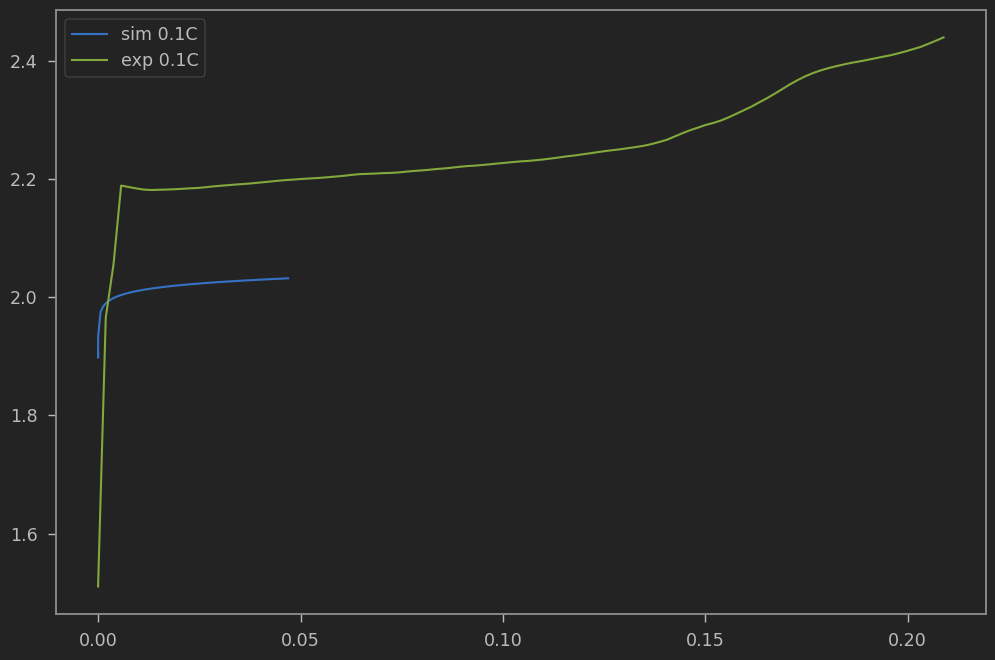

In [76]:
capacity = 0.0211*sim_cha.solution.t/3600
V = sim_cha.solution["Terminal voltage [V]"].entries
plt.plot(capacity, V)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C","exp 0.1C" ])

# Starting from charge

In [124]:
cap = 0.211

Ms = 32
F = 9.649e4
V = 2.45
R = 8.3145
T = 298
ar = 0.960
I = cap*0.2#1.7
nu = 0.114

#f_l = np.sqrt(nu*Ms/2)# (Ms*nu/2)**(1/2)
#f_m = np.sqrt(nu*Ms)#(4*Ms*nu)**(1/2)
#f_h = np.sqrt(nu*Ms)*2/(8**(1/4))#(16*Ms*nu)**(1/4)

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

EL0 = 1.9
EM0 = 2#2.41
EH0 = 2.43

ih0 = 5
im0 = 5
il0 = 5


S8_initial = 10e-100
S1_initial = 10e-5
V_initial = 1.5

def S2_func(S4):
    constant = f_m*np.exp(F*(EM0-V_initial)/(R*T))
    return constant*np.sqrt(S4)

def S4_func(S8):
    constant = f_h*np.exp(2*F*(EH0-V_initial)/(R*T))
    return constant*np.sqrt(S8)

def S1_root(S1):
    
    S4 = S4_func(S8_initial)
    S2 = S2_func(S4)

    EL = EL0 + (R*T/F)*np.log(f_l*S2 / np.sqrt(S1) )
    eta_L = V - EL
    iL = -2*il0*ar*np.sinh(F*eta_L/(2*R*T))
    
    return I - iL

In [125]:
print('S8 initial')
print(S8_initial)

print('S4 initial')
S4_initial = S4_func(S8_initial)
print(S4_initial)

print('S2 initial')
S2_initial = S2_func(S4_initial)
print(S2_initial)

# First find the root for S4
S1 = root(S1_root, 10e-23)
S1_initial = S1['x'][0]
print('S1 initial')
print(S1_initial)

# Check root function is successful
print('Root')
print(S1_root(S1_initial))
'''
# check that V = EM0
print('EM0 initial')
print(EM0 + (R*T)*np.log(f_m*(S4_initial**(1/2))/S2_initial)/(F))

# current check
EH = EH0 + (R*T)*np.log(f_h*(S8_initial**(1/4))/(S4_initial**(1/2)))/(F)
eta_H = V - EH
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))
print('iH initial')
print(iH)

EM = EM0 + (R*T/F)*np.log( f_m*(S4_initial**(1/2)) / S2_initial ) 
eta_M = V - EM
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))
print('iM initial')
print(iM)

print('iH+iM')
print(iH+iM)

# Fourth solve for S1 in terms of S2
S1_initial = S1_func(S2_initial)
print('S1 initial')
print(S1_initial)

# check that V = EL0
print('EL0 initial')
print(EL0 + (R*T)*np.log(f_l*(S2_initial**(1/2))/S1_initial)/(F))
'''

S8 initial
1e-99
S4 initial
1.4910260889828233e-18
S2 initial
0.6670290938753867
S1 initial
1.9845115822584493e-19
Root
-3.1731561822567755e-14


"\n# check that V = EM0\nprint('EM0 initial')\nprint(EM0 + (R*T)*np.log(f_m*(S4_initial**(1/2))/S2_initial)/(F))\n\n# current check\nEH = EH0 + (R*T)*np.log(f_h*(S8_initial**(1/4))/(S4_initial**(1/2)))/(F)\neta_H = V - EH\niH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))\nprint('iH initial')\nprint(iH)\n\nEM = EM0 + (R*T/F)*np.log( f_m*(S4_initial**(1/2)) / S2_initial ) \neta_M = V - EM\niM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))\nprint('iM initial')\nprint(iM)\n\nprint('iH+iM')\nprint(iH+iM)\n\n# Fourth solve for S1 in terms of S2\nS1_initial = S1_func(S2_initial)\nprint('S1 initial')\nprint(S1_initial)\n\n# check that V = EL0\nprint('EL0 initial')\nprint(EL0 + (R*T)*np.log(f_l*(S2_initial**(1/2))/S1_initial)/(F))\n"

In [274]:
EH = EH0 + (R*T)*np.log(f_h*(S8_initial**(1/2))/S4_initial)/(2*F)
eta_H = V_initial - EH
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))
print('EH initial')
print(EH)
print('eta_H initial')
print(eta_H)
print('iH initial')
print(iH)

EH initial
2.2191368535224294
eta_H initial
-0.01913685352242922
iH initial
3.660544981767994


In [2]:


cap = 0.211

Ms = 32
F = 9.649e4

R = 8.3145
T = 298
ar = 0.960
I = cap*0.2#1.7
nu = 0.114

#f_l = np.sqrt(nu*Ms/2)# (Ms*nu/2)**(1/2)
#f_m = np.sqrt(nu*Ms)#(4*Ms*nu)**(1/2)
#f_h = np.sqrt(nu*Ms)*2/(8**(1/4))#(16*Ms*nu)**(1/4)

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

EL0 = 1.9
EM0 = 2#2.41
EH0 = 2.43

ih0 = 5
im0 = 5
il0 = 5



In [3]:
S1_initial_cha = 1e-4
V_initial_cha = 2.0
I = -0.0211
def S2_func(S1):
    constant = np.exp((2*F/(R*T))*(V_initial_cha - (2*R*T/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

def S4_func(S2):
    constant = np.exp((2*F/(R*T))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

def S8_func(S4):
    constant = np.exp((4*F/(R*T))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

In [4]:
S2_initial_cha = S2_func(S1_initial_cha)
S4_initial_cha = S4_func(S2_initial_cha)
S8_initial_cha = S8_func(S4_initial_cha)
print(S1_initial_cha)
print(S2_initial_cha)
print(S4_initial_cha)
print(S8_initial_cha)

0.0001
1.3113145894720819e-05
4.7136676331204344e-11
2.4757339893739964e-51


In [5]:
EH = EH0 + (R*T)*np.log(f_h*(S8_initial_cha**(1/4))/(S4_initial_cha**(1/2)))/(F)
eta_H = V_initial_cha - EH
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))
print('EH initial')
print(EH)
print('eta_H initial')
print(eta_H)
print('iH initial')
print(iH)

EM = EM0 + (R*T)*np.log(f_m*(S4_initial_cha**(1/2))/S2_initial_cha)/(F)
eta_M = V_initial_cha - EM
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))
print('EM initial')
print(EM)
print('eta_M initial')
print(eta_M)
print('iM initial')
print(iM)

EL = EL0 + (R*T/F)*np.log(f_l*(S2_initial_cha**(1/2))/S1_initial_cha)
eta_L = V_initial_cha - EL
iL = -2*il0*ar*np.sinh(F*eta_L/(2*R*T))
print('EL initial')
print(EL)
print('eta_L initial')
print(eta_L)
print('iL initial')
print(iL)

EH initial
2.0
eta_H initial
0.0
iH initial
-0.0
EM initial
2.0
eta_M initial
0.0
iM initial
-0.0
EL initial
1.9998871215691447
eta_L initial
0.00011287843085527882
iL initial
-0.021100000000008695


In [283]:
Sp_initial_cha = 0.3
model_cha = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha = model_cha.default_parameter_values
param_cha.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S1_initial_cha*.125,#*.0145,
        'gamma': 10e1,#10,#10e40,#10,
        'kappa': 10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 5000
        
        }
)


sim_cha = pybamm.Simulation(
    model_cha,
    #experiment=experiment,
    parameter_values = param_cha,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .1,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 500#.67*7000#16950#3600*hours
sim_cha.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

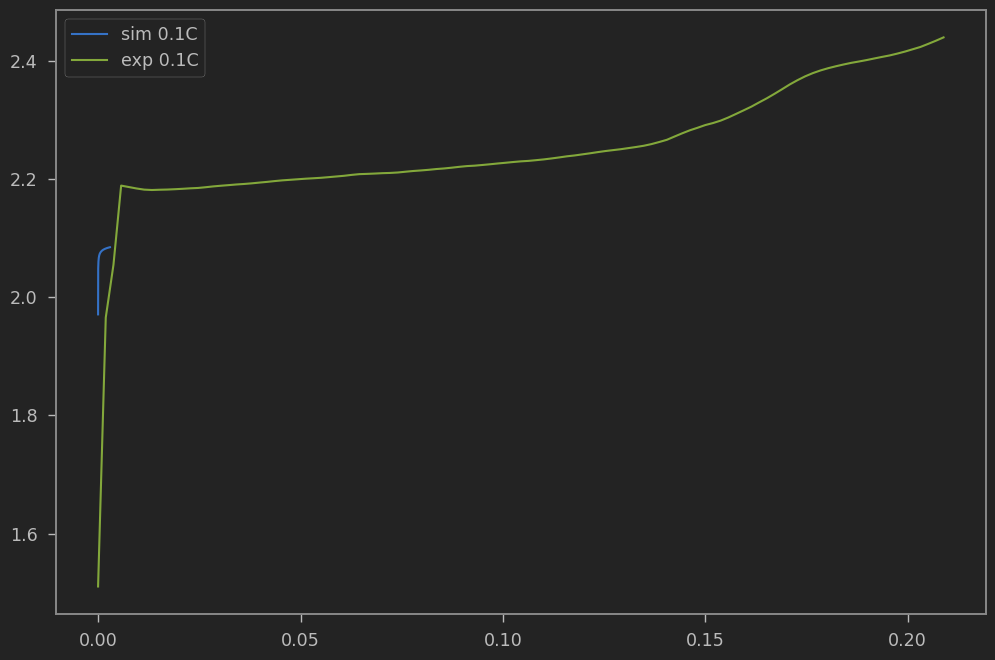

In [284]:
capacity = 0.0211*sim_cha.solution.t/3600
V = sim_cha.solution["Terminal voltage [V]"].entries
plt.plot(capacity, V)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C","exp 0.1C" ])

In [285]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = 360000#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        print("Time's up!")
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    elif sim.solution['Terminal voltage [V]'].entries[-1] > 2.49:
        print('High Voltage!')
        return True
    else:
        return False

    
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 500 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(500)
    except:
        condition = False
        
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(1)
    except:
        condition = False






 Trying 500 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

High Voltage!





 Trying 100 





High Voltage!





 Trying 50 










 Trying 10 










 Trying 1 







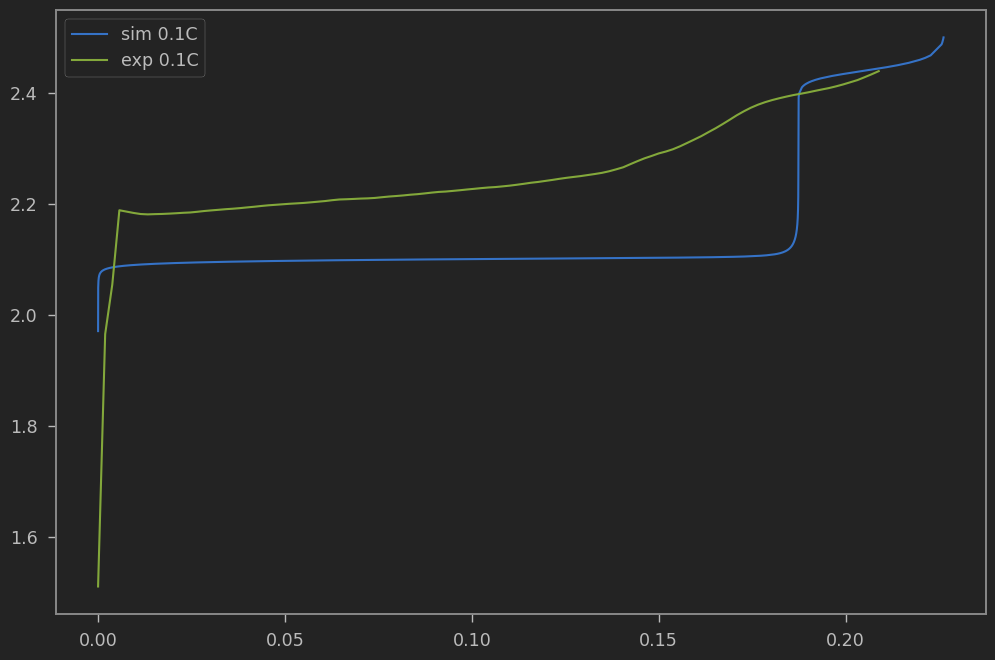

In [286]:
capacity = 0.0211*sim_cha.solution.t/3600
V = sim_cha.solution["Terminal voltage [V]"].entries
plt.plot(capacity, V)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C","exp 0.1C" ])

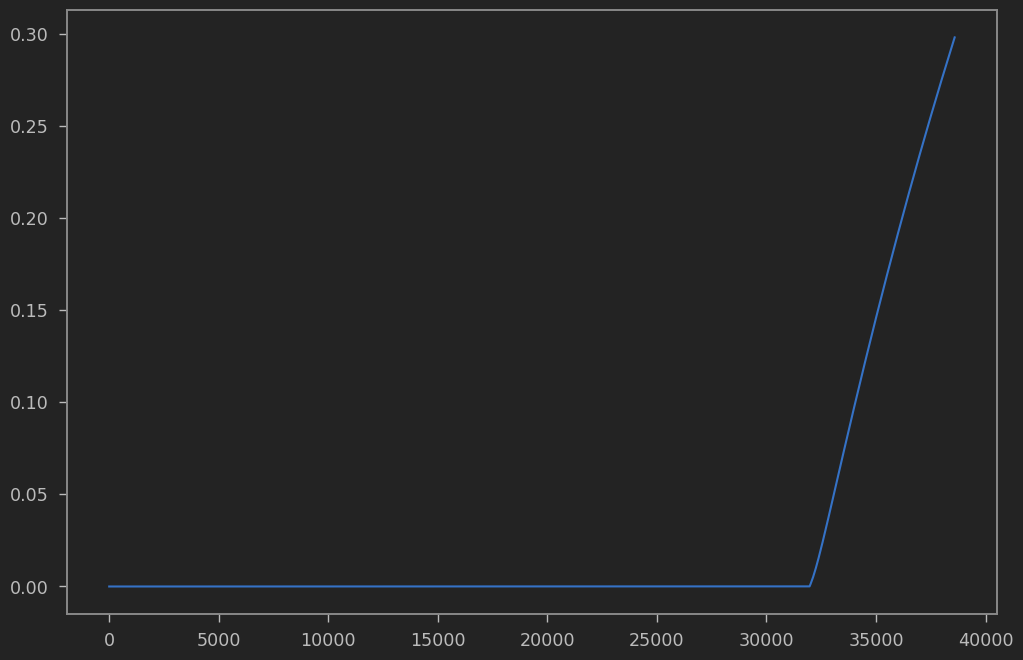

In [287]:
time = sim_cha.solution.t
S1 = sim_cha.solution["S [g]"].entries
S2 = sim_cha.solution["S2 [g]"].entries
S4 = sim_cha.solution["S4 [g]"].entries
S8 = sim_cha.solution["S8 [g]"].entries
Sp = sim_cha.solution["Precipitated Sulfur [g]"].entries

plt.plot(time,S8)
#plt.plot(sim_cha.solution.t,sim_cha.solution["S2 [g]"].entries)
#plt.plot(sim_cha.solution.t,sim_cha.solution["S4 [g]"].entries)
#plt.plot(sim_cha.solution.t,sim_cha.solution["S8 [g]"].entries)

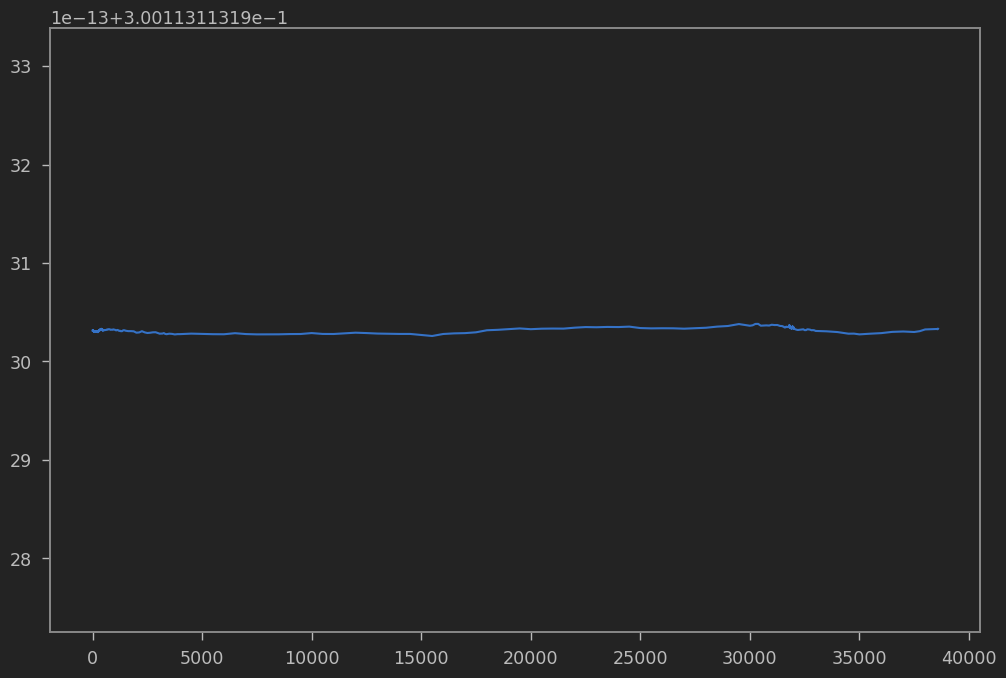

In [288]:
plt.plot(time, S1+S2+S4+S8+Sp)

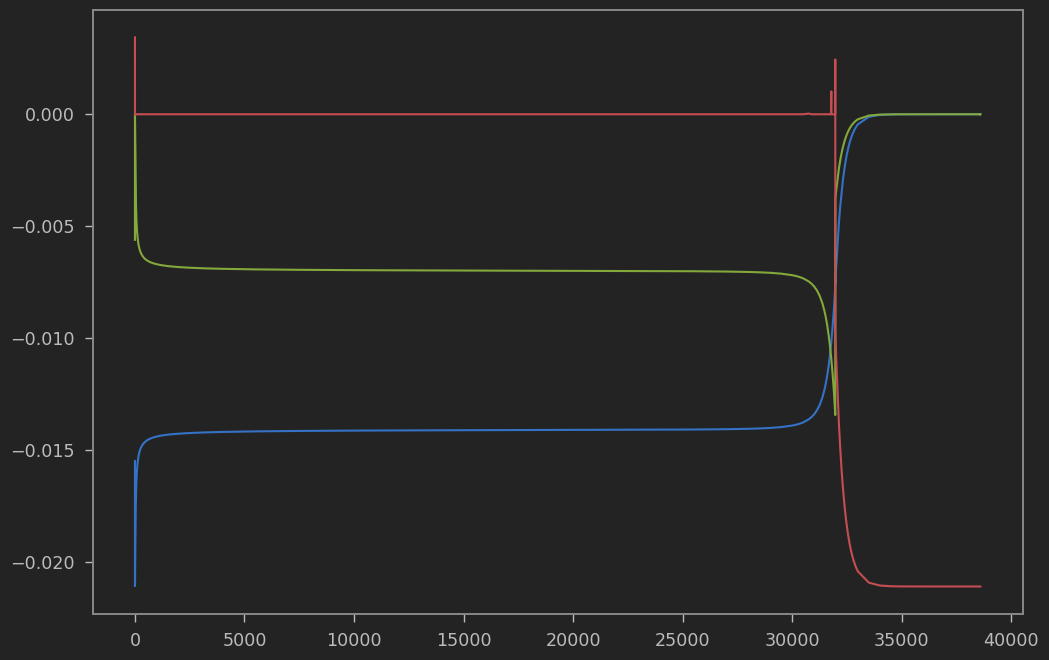

In [289]:
iL = sim_cha.solution["Low plateau current [A]"].entries
iM = sim_cha.solution["Middle plateau current [A]"].entries
iH = sim_cha.solution["High plateau current [A]"].entries


plt.plot(sim_cha.solution.t,sim_cha.solution["Low plateau current [A]"].entries)
plt.plot(sim_cha.solution.t,sim_cha.solution["Middle plateau current [A]"].entries)
plt.plot(sim_cha.solution.t,sim_cha.solution["High plateau current [A]"].entries)

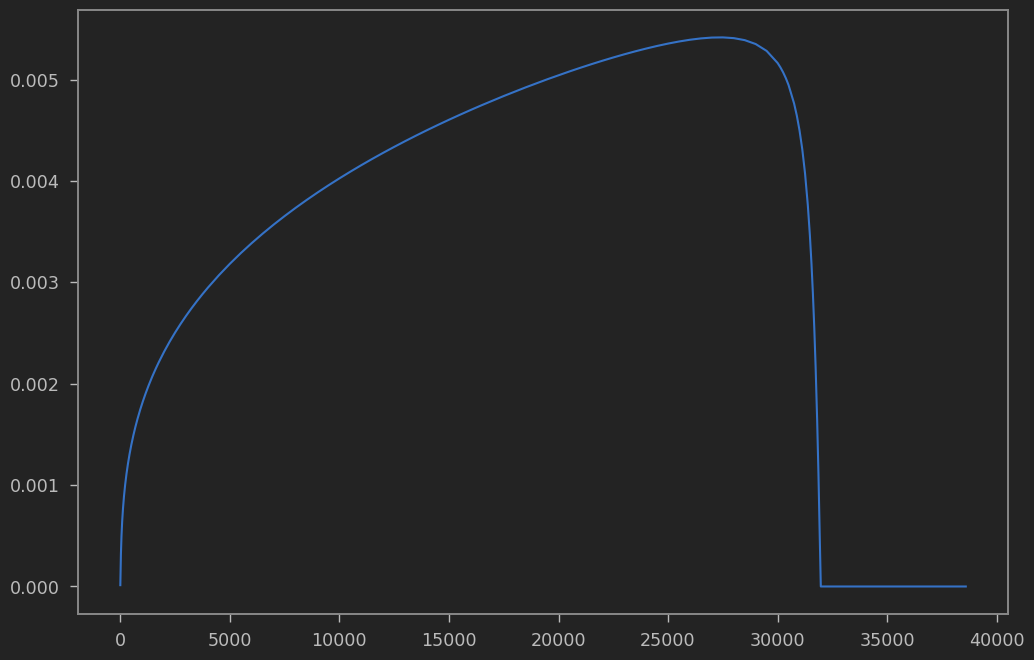

In [290]:
plt.plot(time,S2)

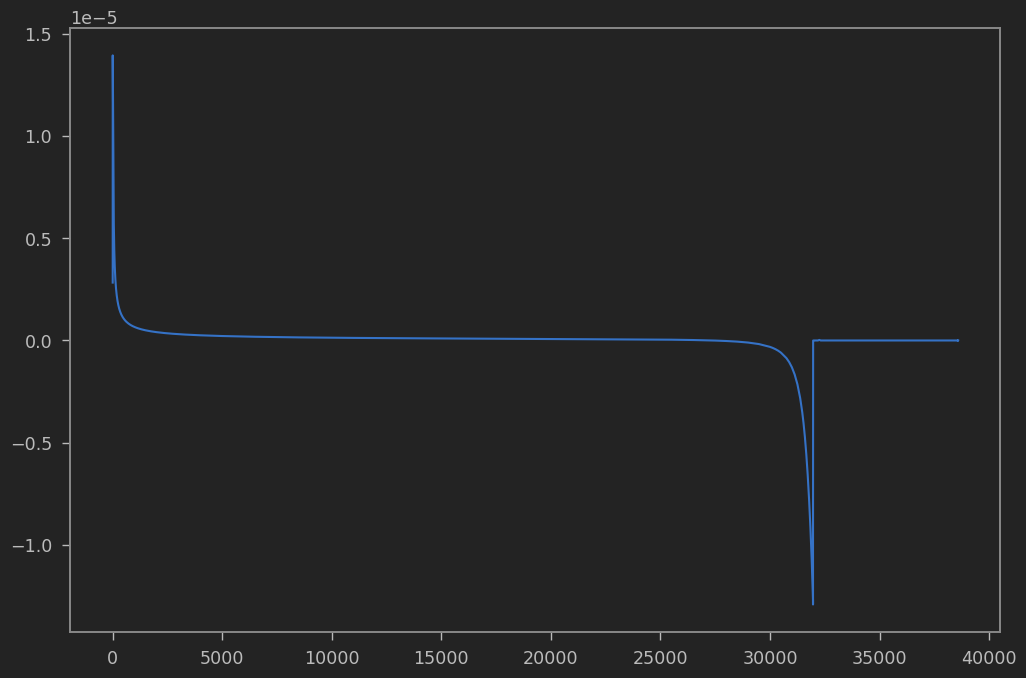

In [291]:
plt.plot(time, 4 * Ms * iM / (1 * F) - (2 * Ms * iL / (1 * F)) )

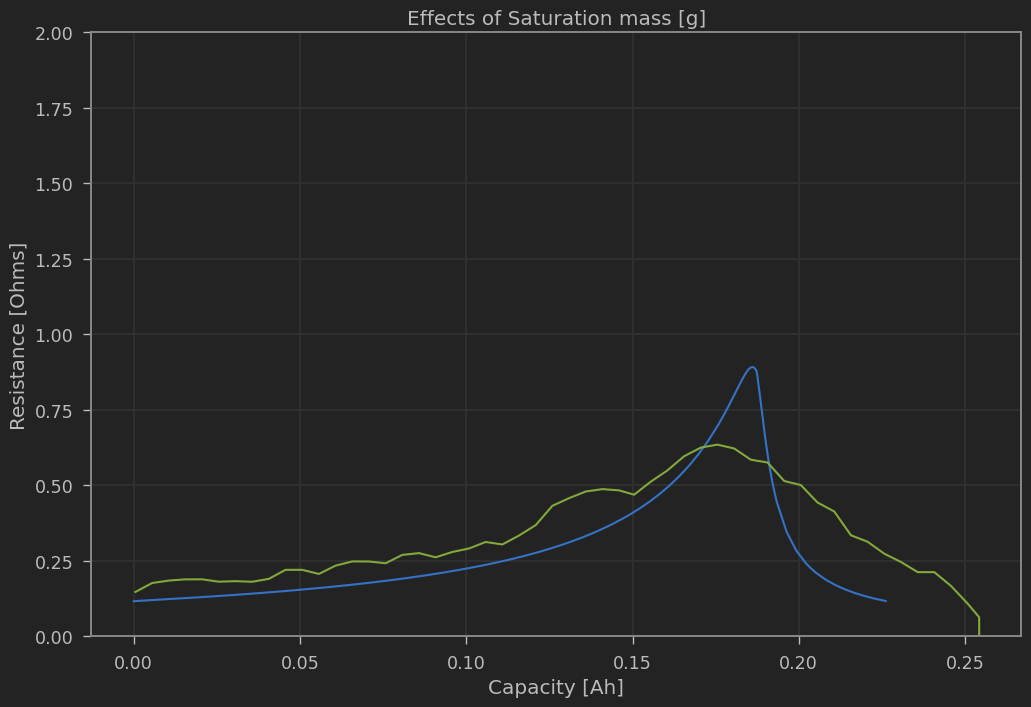

In [358]:
sigma_0 = 2e-2
l =  4e-5
A = 0.15

capacity = .0211*sim_cha.solution.t/3600
S4 = sim_cha.solution['S4 [g]'].entries
S2 = sim_cha.solution['S2 [g]'].entries
S1 = sim_cha.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 
b = 8e-2
sigma = sigma_0 - b*(Li)
R = l/(A*sigma)
#plt.plot(capacity,R)
plt.plot(sim_cha.solution.t*0.0211/3600,.01/(max(Li)*1.15-Li))

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']
plt.plot(res_charge_data['30'][0],res_charge_data['30'][1])

plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)

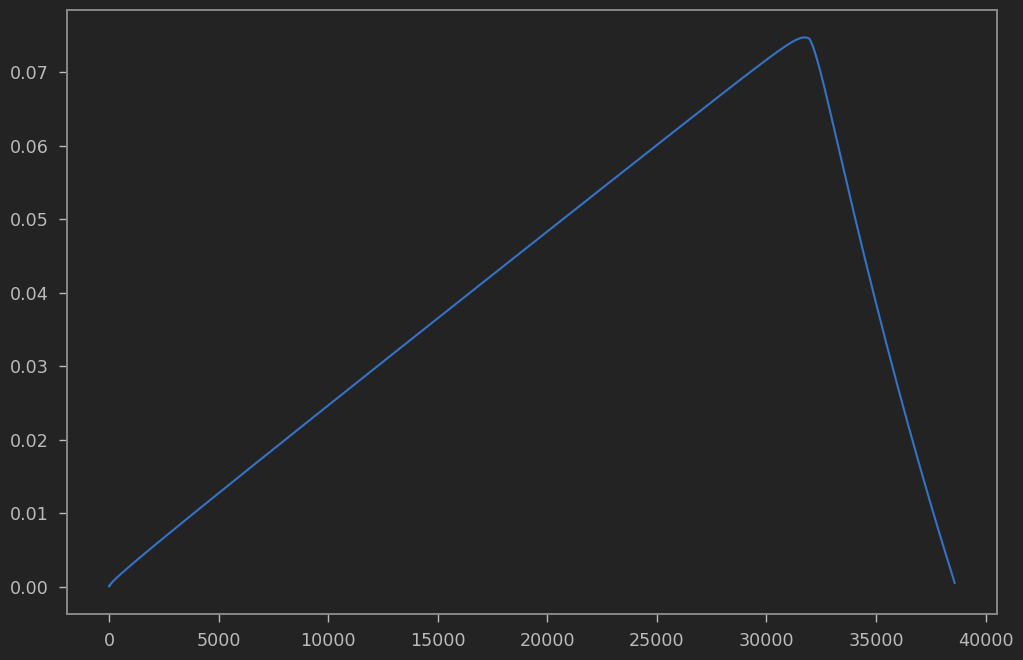

In [293]:
plt.plot(sim_cha.solution.t,Li)

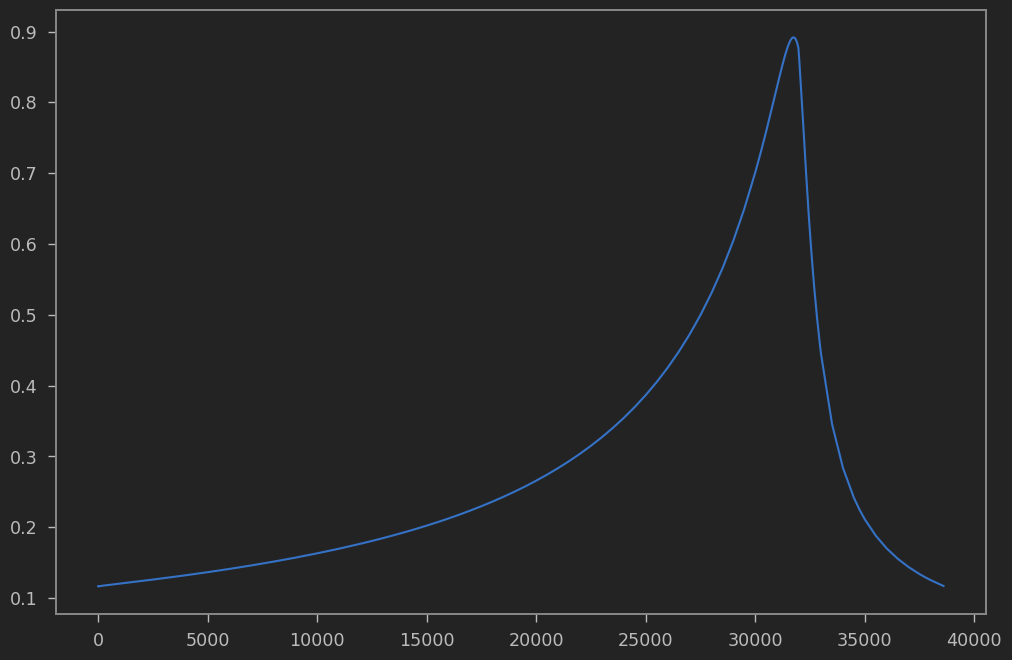

In [294]:
plt.plot(sim_cha.solution.t,.01/(max(Li)*1.15-Li))

In [370]:
loc = -100

S1_initial = S1[loc]
S2_initial = S2[loc]
S4_initial = S4[loc]
S8_initial = S8[loc]
Sp_initial = Sp[loc]
V_initial = sim_cha.solution['Terminal voltage [V]'].entries[loc]

In [371]:
V_initial

2.3972569334828235

In [ ]:
model = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param = model.default_parameter_values
param.update(
    {
        "Current function [A]": .0422,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S1_initial_cha*.125,
        'gamma': 0,#10e40,
        'kappa': 0,#10e12,
        'Shuttle rate coefficient during charge [s-1]': 0,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 1000
        
        }
)


sim = pybamm.Simulation(
    model,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-5,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 2500#16950#3600*hours
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [ ]:
plt.plot(sim.solution.t*0.0422/3600,sim.solution["Terminal voltage [V]"].entries)

In [ ]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = 19500#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    else:
        return False

condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(1)
    except:
        condition = False

In [ ]:
plt.plot(sim.solution.t*0.0422/3600,sim.solution["Terminal voltage [V]"].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])